In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import seaborn as sns
import re
from shutil import copy2
import cv2

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint
import pocketsphinx

## Bag 1 : Classification Hijaiyah

### Menampilkan gambar dataset

Total data gambar: 13440
Shape setiap gambar: (128, 128, 3)


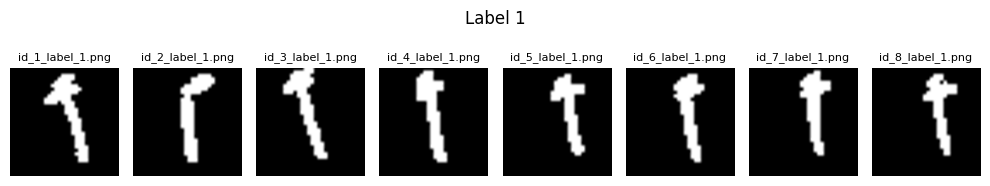

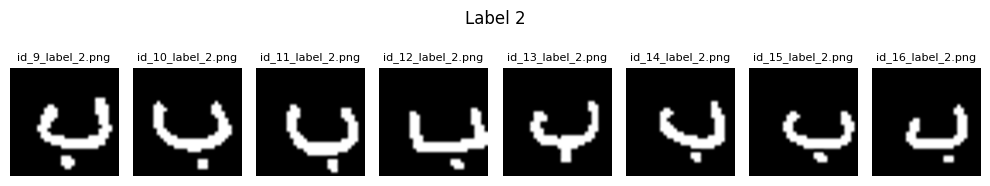

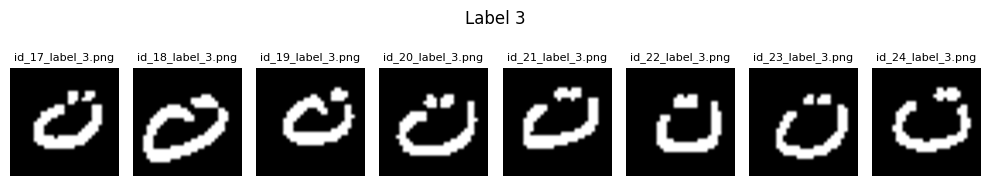

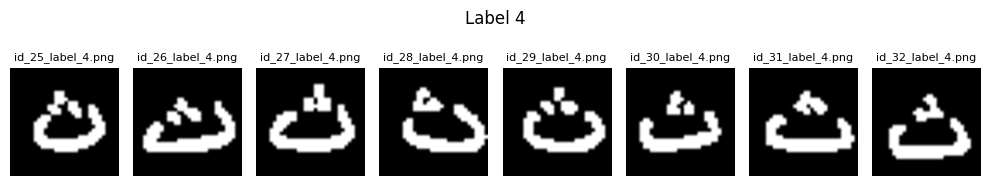

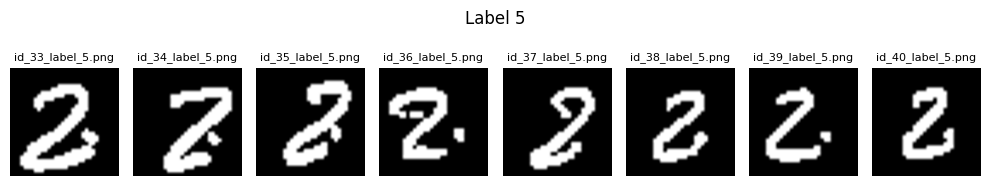

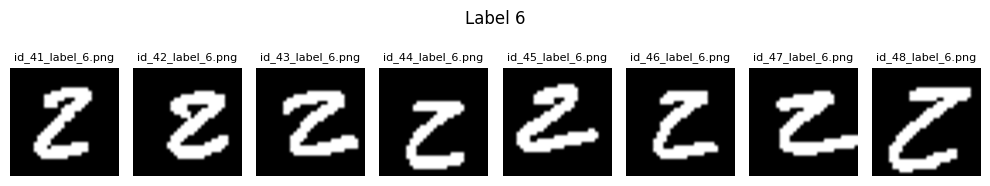

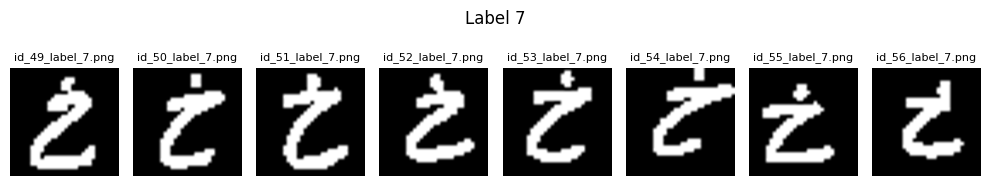

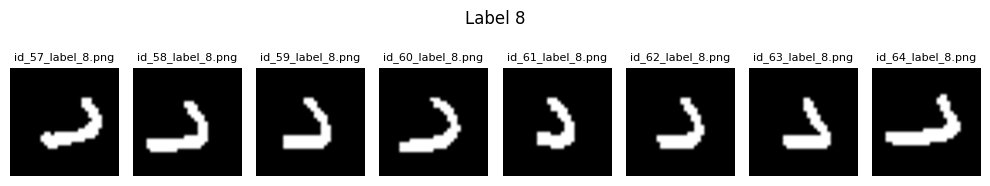

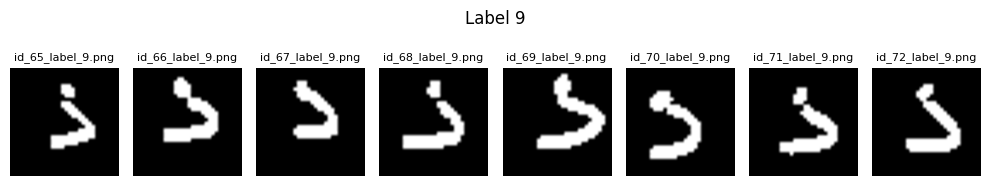

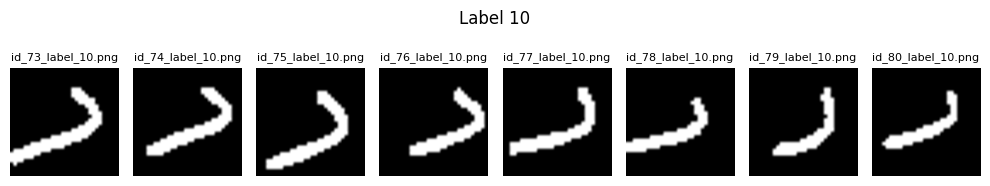

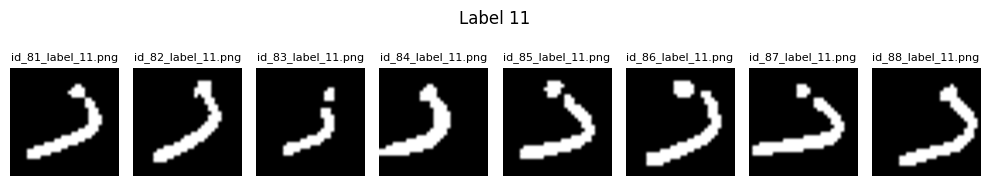

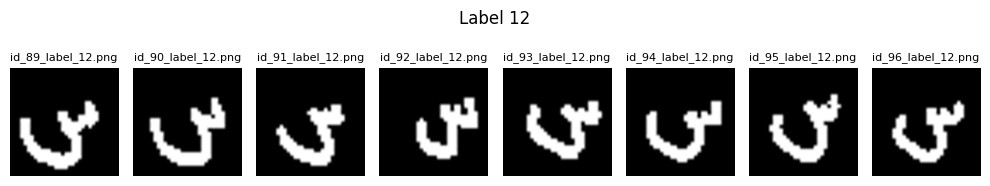

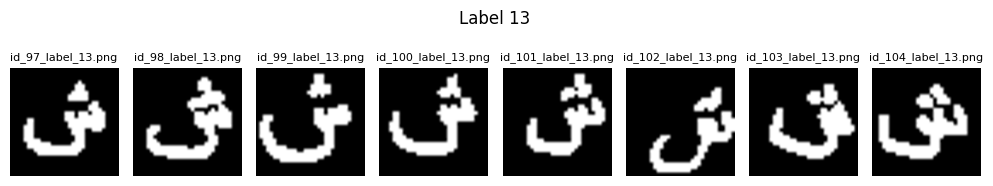

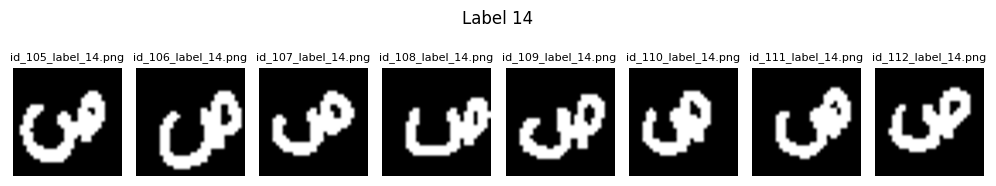

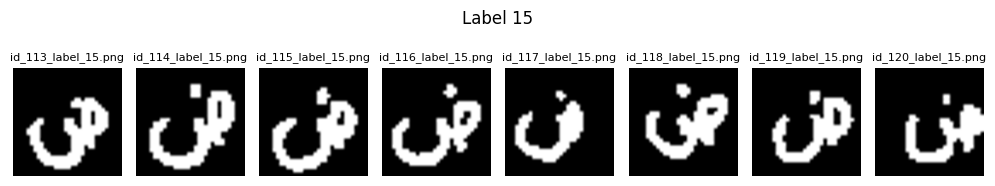

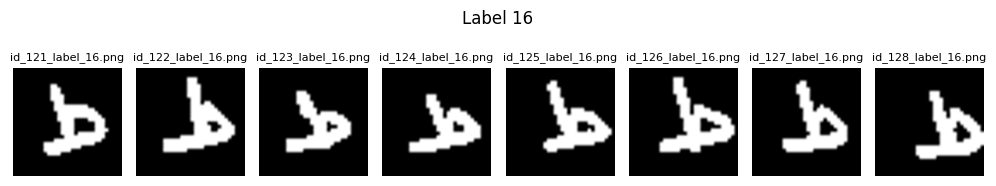

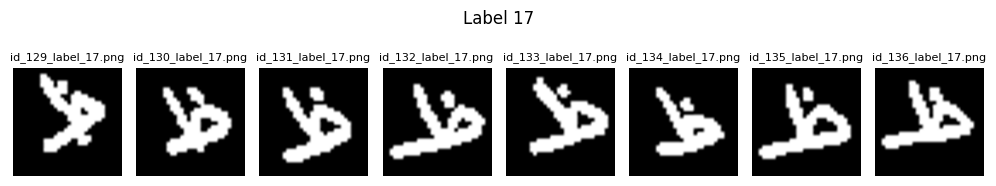

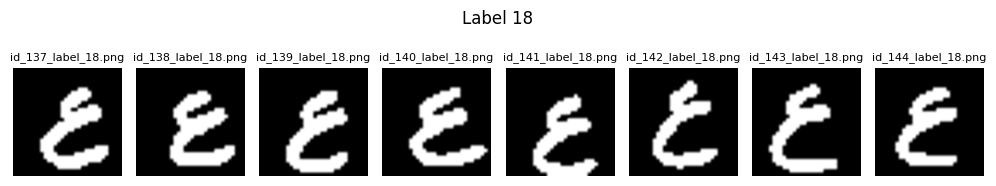

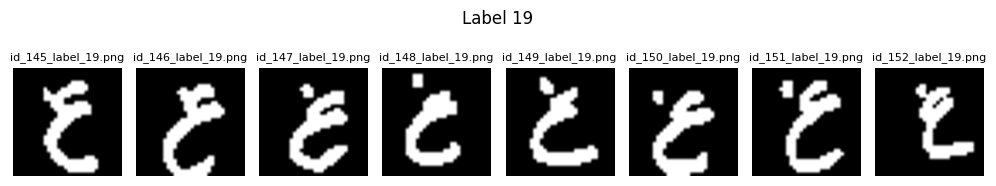

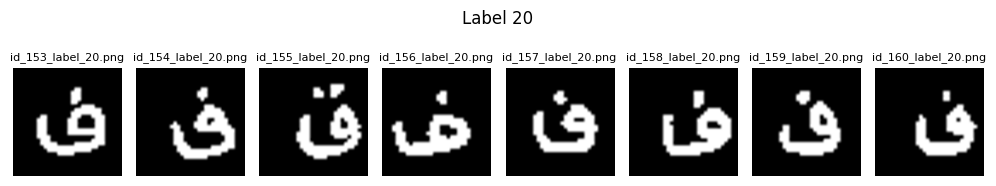

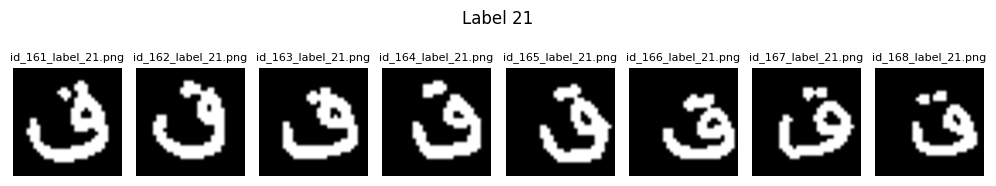

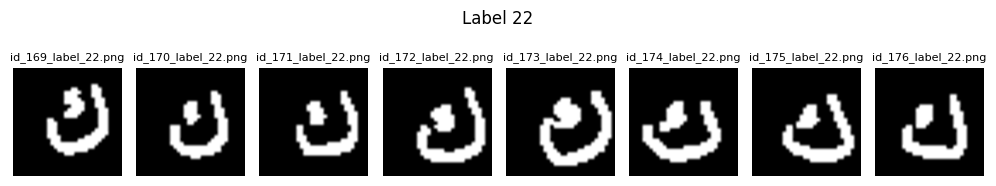

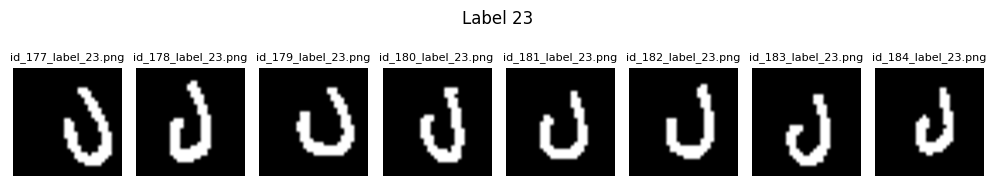

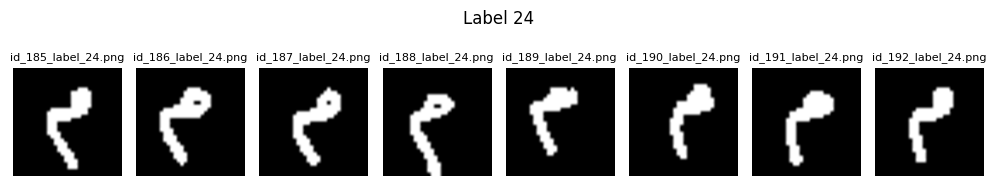

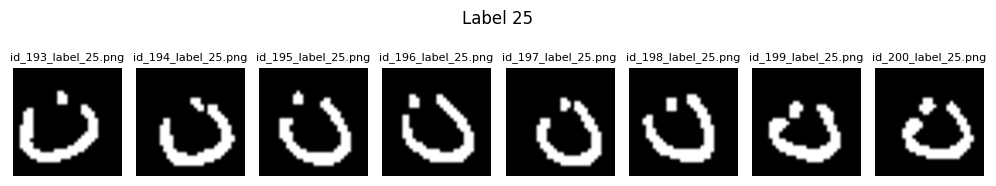

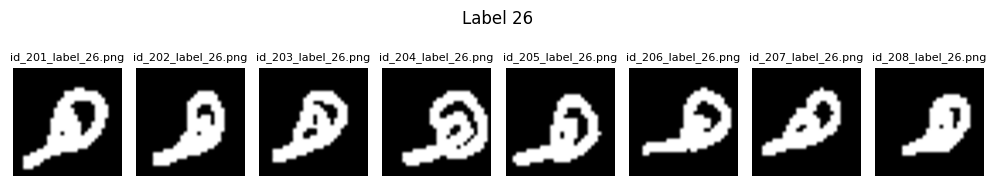

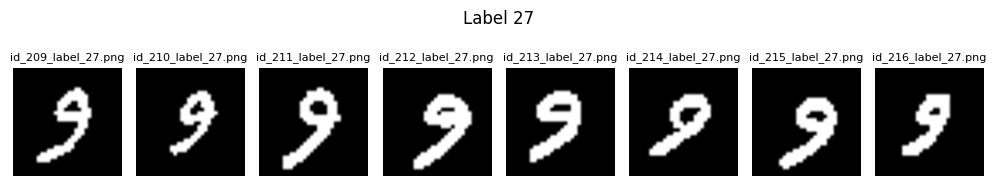

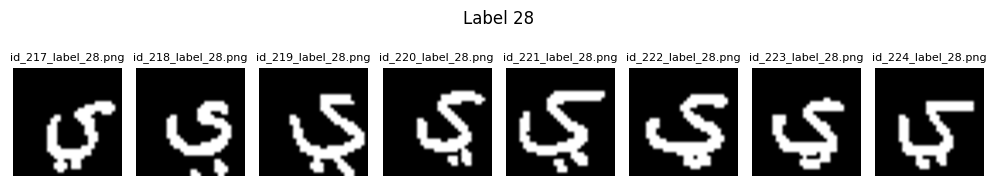

In [2]:
source_folder = r"C:\Users\gagah\Desktop\KKN\data\Train Images 13440x32x32\train"
size = 128

images_with_filenames = []

def extract_id(filename):
    match = re.search(r'id_(\d+)_', filename)
    return int(match.group(1)) if match else -1

file_list = [f for f in os.listdir(source_folder) if f.endswith(".jpg") or f.endswith(".png")]
file_list.sort(key=extract_id)

for filename in file_list:
    img_path = os.path.join(source_folder, filename)
    img = Image.open(img_path).convert('RGB') 
    img = img.resize((size, size))
    img_array = np.array(img)
    images_with_filenames.append((img_array, filename))

images = np.array([img[0] for img in images_with_filenames])
filenames = [img[1] for img in images_with_filenames]

print(f'Total data gambar: {len(images)}')
print(f'Shape setiap gambar: {images[0].shape}')


# Memunculkan gambar
# Memisahkan gambar berdasarkan label
label_dict = {}
for img_array, filename in images_with_filenames:
    match = re.search(r'label_(\d+)', filename)
    if match:
        label = int(match.group(1))
        if label not in label_dict:
            label_dict[label] = []
        label_dict[label].append((img_array, filename))

# Menampilkan gambar per label
for label, images in label_dict.items():
    fig, axes = plt.subplots(1, 8, figsize=(10, 2))
    axes = axes.ravel()
    for i in range(min(8, len(images))):
        axes[i].imshow(images[i][0])
        axes[i].axis('off')
        axes[i].set_title(images[i][1], fontsize=8)
    plt.suptitle(f'Label {label}')
    plt.tight_layout()
    plt.show()

### Memisahkan dataset sesuai label

In [3]:
# memisahkan data di folder utama menjadi sub folder
source_folder = r"C:\Users\gagah\Desktop\KKN\data\Train Images 13440x32x32\train"
destination_folder = r"C:\Users\gagah\Desktop\KKN\data\Data_Train_Images"

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)
file_list = [f for f in os.listdir(source_folder) if f.endswith(".jpg") or f.endswith(".png")]

for filename in file_list:
    match = re.search(r'id_(\d+)_label_(\d+)', filename)
    if match:
        img_id = match.group(1)
        label = match.group(2)
        
        # Membuat path folder label
        label_folder = os.path.join(destination_folder, f'lab_{label}')
        if not os.path.exists(label_folder):
            os.makedirs(label_folder)
        
        # Menyalin file ke folder tujuan dengan nama file baru
        src_path = os.path.join(source_folder, filename)
        dest_path = os.path.join(label_folder, f'id_{img_id}.png')
        copy2(src_path, dest_path)

### Membuat model DeepLearning

In [ ]:
TRAINING_DIR = "data\Data_Train_Images"

model_dir = 'model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,      # Meningkatkan rotation range
    shear_range=0.4,
    zoom_range=0.2,         # Menambahkan zoom range
    width_shift_range=0.2,  # Menambahkan width shift
    height_shift_range=0.2, # Menambahkan height shift
    fill_mode='nearest',    # Mode pengisian
    validation_split=0.2    # Split validation
)

train_generator = datagen.flow_from_directory(
    directory=TRAINING_DIR,
    target_size=(size, size),
    batch_size=32,
    class_mode='categorical',
    subset='training' 
)

validation_generator = datagen.flow_from_directory(
    directory=TRAINING_DIR,
    target_size=(size, size),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(size, size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    Dropout(0.5),
    tf.keras.layers.Dense(len(label_dict.keys()), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(model_dir, 'model_{epoch:02d}_{val_accuracy:.2f}.h5'),  # Nama file dengan epoch dan akurasi validasi
    monitor='val_accuracy',    # Metrik yang dipantau
    save_best_only=True,       # Hanya menyimpan model terbaik
    mode='max',                # Mode 'max' karena kita ingin akurasi maksimum
    verbose=1                  # Menampilkan log setiap kali model disimpan
)

model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback]
)

### Evaluation model

420/420 [==============================] - 24s 54ms/step


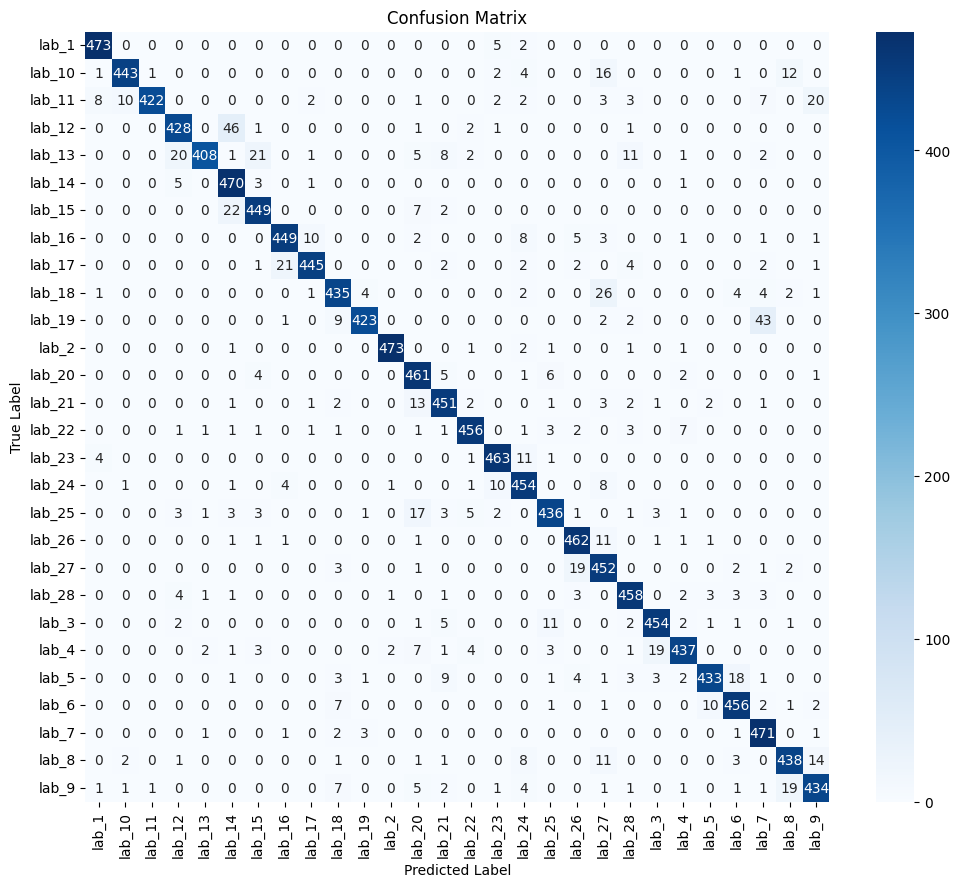

              precision    recall  f1-score   support

       lab_1       0.97      0.99      0.98       480
      lab_10       0.97      0.92      0.95       480
      lab_11       1.00      0.88      0.93       480
      lab_12       0.92      0.89      0.91       480
      lab_13       0.99      0.85      0.91       480
      lab_14       0.85      0.98      0.91       480
      lab_15       0.92      0.94      0.93       480
      lab_16       0.94      0.94      0.94       480
      lab_17       0.96      0.93      0.94       480
      lab_18       0.93      0.91      0.92       480
      lab_19       0.98      0.88      0.93       480
       lab_2       0.99      0.99      0.99       480
      lab_20       0.88      0.96      0.92       480
      lab_21       0.92      0.94      0.93       480
      lab_22       0.96      0.95      0.96       480
      lab_23       0.95      0.96      0.96       480
      lab_24       0.91      0.95      0.93       480
      lab_25       0.94    

In [4]:
label_mapping = {
    'lab_1': 'alif',
    'lab_2': 'ba',
    'lab_3': 'ta',
    'lab_4': 'tsa',
    'lab_5': 'jim',
    'lab_6': 'ha',
    'lab_7': 'kho',
    'lab_8': 'dal',
    'lab_9': 'dzal',
    'lab_10': 'ra',
    'lab_11': 'zai',
    'lab_12': 'sin',
    'lab_13': 'syin',
    'lab_14': 'shad',
    'lab_15': 'dhad',
    'lab_16': 'tha',
    'lab_17': 'dha',
    'lab_18': 'ain',
    'lab_19': 'ghain',
    'lab_20': 'fa',
    'lab_21': 'qaf',
    'lab_22': 'kaf',
    'lab_23': 'lam',
    'lab_24': 'mim',
    'lab_25': 'nun',
    'lab_26': 'ha',
    'lab_27': 'waw',
    'lab_28': 'ya'
}


def load_and_preprocess_image(img_path, target_size=(128, 128)):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

def load_images_from_folders(base_folder):
    images = []
    labels = []
    class_names = os.listdir(base_folder)
    
    for class_index, class_name in enumerate(class_names):
        class_folder = os.path.join(base_folder, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                if filename.endswith(".png"):
                    img_path = os.path.join(class_folder, filename)
                    img_array = load_and_preprocess_image(img_path)
                    images.append(img_array)
                    labels.append(class_index)
    
    images = np.vstack(images)  # Combine all images into one large array
    labels = np.array(labels)
    return images, labels, class_names

# Load the model
model = load_model('model/model_38_0.86.h5')

# Path to the dataset folder
base_folder = 'data/Data_Train_Images'

# Load and preprocess images
images, true_labels, class_names = load_images_from_folders(base_folder)

# Predict the class
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Display confusion matrix with new labels
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report with new labels
print(classification_report(true_labels, predicted_classes, target_names=class_names))

1/1 [==============================] - 0s 82ms/step


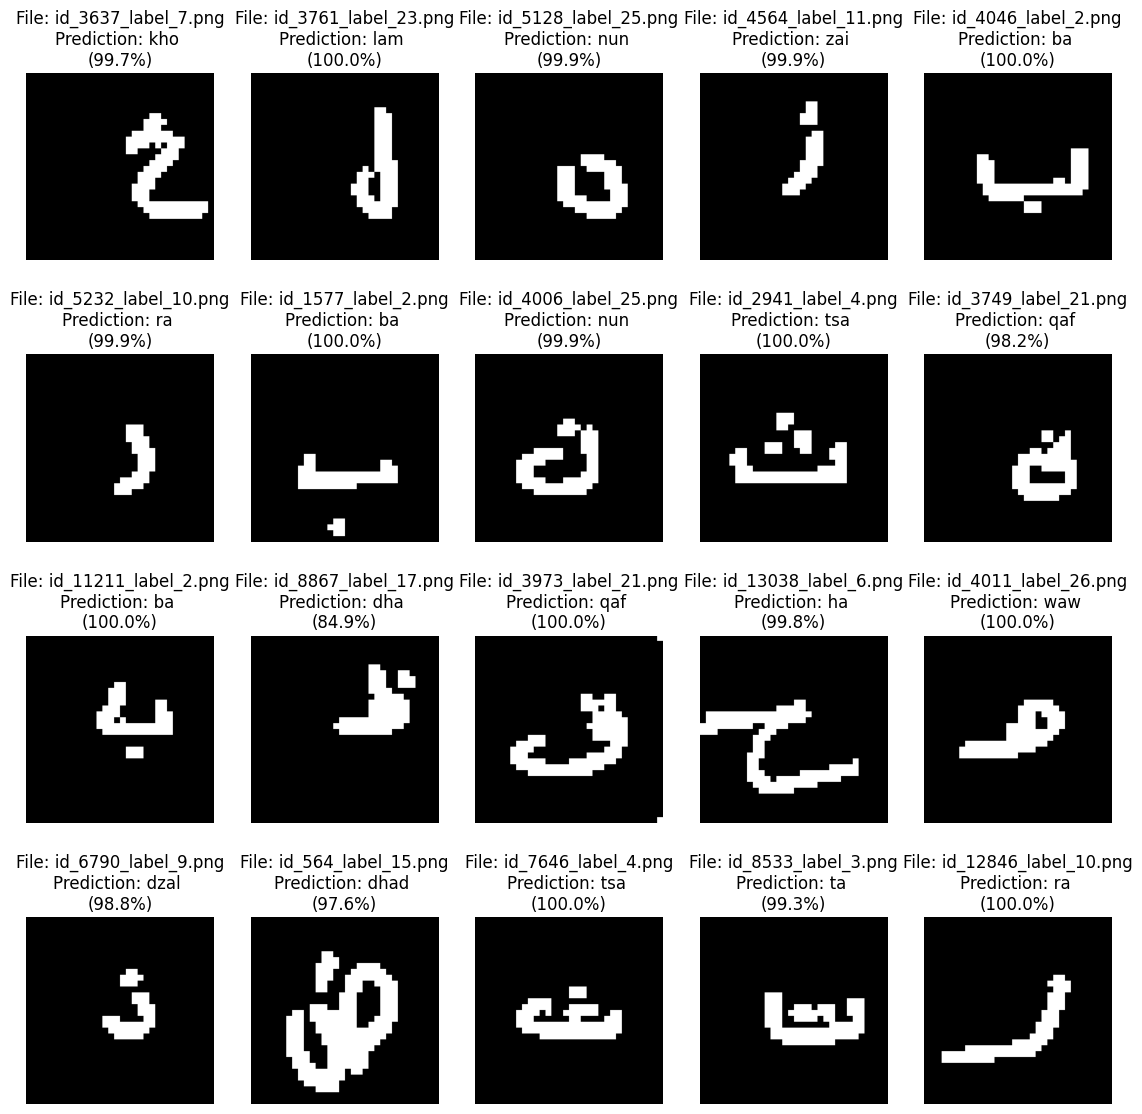

In [14]:
import random

lab_mapping = {
    0: 'alif',
    1: 'ra',
    2: 'zai',
    3: 'sin',
    4: 'syin',
    5: 'shad',
    6: 'dhad',
    7: 'tha',
    8: 'dha',
    9: 'ain',
    10: 'gha',
    11: 'ba',
    12: 'fa',
    13: 'qaf',
    14: 'kaf',
    15: 'lam',
    16: 'mim',
    17: 'nun',
    18: 'waw',
    19: 'ha',
    20: 'ya',
    21: 'ta',
    22: 'tsa',
    23: 'jim',
    24: 'ha',
    25: 'kho',
    26: 'dal',
    27: 'dzal'
}

# Ambil sampel acak dari folder
sample_size = 20  # Jumlah sampel yang ingin diambil
sample_files = random.sample(os.listdir(source_folder), sample_size)

# Muat gambar dan proses untuk prediksi
images = []
for file in sample_files:
    img_path = os.path.join(source_folder, file)
    img = load_img(img_path, target_size=(128, 128))  # Sesuaikan ukuran target dengan model Anda
    img_array = img_to_array(img) / 255.0  # Rescale gambar
    images.append(img_array)

# Convert list images ke numpy array
images = np.array(images)

# Prediksi menggunakan model
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)

# Menampilkan gambar dengan label asli dan prediksi
plt.figure(figsize=[14, 14])
for i in range(sample_size):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title("File: {}\nPrediction: {} \n({:.1f}%)".format(
        sample_files[i],
        lab_mapping[predicted_classes[i]],
        np.max(predictions[i]) * 100
    ))

plt.show()


### Ubah model menjadi TfLite

In [16]:
# Load model Keras (.h5)
model = tf.keras.models.load_model('model/model_38_0.86.h5')

# Konversi model ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TensorFlow Lite (.tflite)
with open('model_86.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke .tflite")

INFO:tensorflow:Assets written to: C:\Users\gagah\AppData\Local\Temp\tmpdemcbfmj\assets


INFO:tensorflow:Assets written to: C:\Users\gagah\AppData\Local\Temp\tmpdemcbfmj\assets


Model berhasil dikonversi ke .tflite
